# INCORPORATING DATA SCIENCE AND CLIMATE IN COASTAL ENGINEERING
### The 4th International Symposium of Water Disaster Mitigation and Water Environment Regulation


<img src="images/Image_3.png" alt="Texto alternativo" width="700">  


## TESLA: 01 - DAILY WEATHER TYPES: SENSIVILITY ANALYSIS



---

Fernando J.Mendez (fernando.mendez@unican.es)

Full Profesor at the Univeristy of Cantabria

---

Jared Ortiz-Angulo Cantos (ortizanguloj@unican.es)

Researcher

---

Geomatics and Ocean Engineering Group

Civil Engineering School, University of Cantabria

<img src="images/Image_1.png" alt="Texto alternativo" width="200">               <img src="images/Image_2.jpeg" alt="Texto alternativo" width="200">

<img src="images/Image_4.jpeg" alt="Texto alternativo" width="800"> 

© GeoOcean 2024 - University of Cantabria


---

Inputs required:
  * Sea Level Pressure (Predictor) (ERA5)
  * Storm Surge data (Predictant) (CoDEC)
  * Wave data (Predictant) (ERA5)

  
In this notebook:
  1. Import required libraries and input paths
  2. Load Predictor: SLP (Sea Level Pressure) - ERA5
  3. Calculate SLP Gradient
  4. Load Predictands
  5. Principal Component Analysis (PCA)
  6. K-MEANS Classification
  7. Predictand associated to each WT
  8. Save data


---

## **1. Import required libraries and input paths**

In [2]:
import warnings
warnings.filterwarnings('ignore')

# system
import os
import os.path as op

import sys

import datetime
import numpy as np
import pandas as pd
import xarray as xr

# matlab files
import scipy.io

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
import matplotlib.dates as mdates
import plotly.express as px

import regionmask
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [3]:
from bluemath_tk.teslakit2.toolkit.pca import PCA_EstelaPred_slp_grd
from bluemath_tk.teslakit2.toolkit.mda import normalize, denormalize

from bluemath_tk.teslakit2.toolkit.estela import spatial_gradient
from bluemath_tk.teslakit2.plotting.estela import Plot_Estela, Plot_EOFs_EstelaPred, Plot_DWTs_Mean_Anom, Plot_DWTs_Probs
from bluemath_tk.teslakit2.plotting.custom_colors import colors_dwt

from bluemath_tk.teslakit2.toolkit.kma import slp_kmeans_clustering
from bluemath_tk.teslakit2.plotting.pcs import Plot_PCs_WT

In [8]:
# paths
p_dat = ('/home/ortizaj/Desktop/UCSC/github/BM-HongKong/data')
p_out = ('/home/ortizaj/Desktop/UCSC/HONG_KONG_COURSE/results')

---

## **2. LOAD PREDICTOR: SLP (SEA LEVEL PRESSURE) - ERA5**

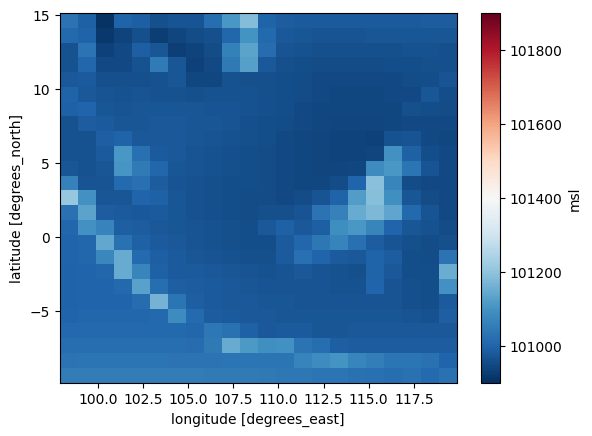

In [5]:
# load and plot SLP data

xds_SLP = xr.open_dataset(op.join(p_dat, 'singapore_mslp_1day_1degree.nc')).load()
xds_SLP = xds_SLP.isel(time = range(len(xds_SLP.time) - 70)) # remove some time values
xds_SLP.msl.mean(dim = 'time').plot(cmap = 'RdBu_r', vmin = 101400-500, vmax = 101400+500)

In [6]:
# change longitude format
xds_SLP['longitude'] = (('longitude'), np.where(xds_SLP.longitude.values>180, xds_SLP.longitude.values-360, xds_SLP.longitude.values))

---

## **3. CALCULATE SLP GRADIENT**

In [6]:
xds_SLP = xds_SLP.sortby('latitude').sortby('longitude')

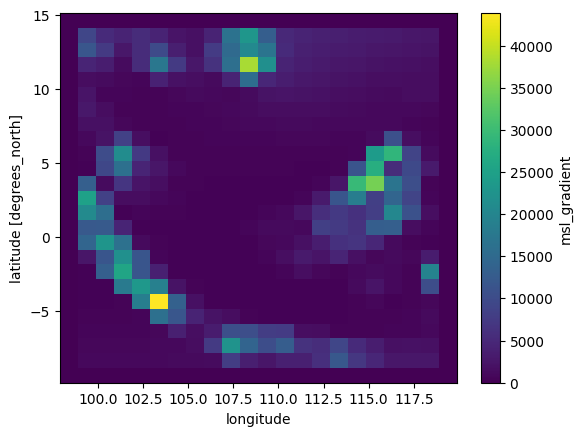

In [7]:
xds_SLP = spatial_gradient(xds_SLP, 'msl') # function to calculate the pressure gradient
xds_SLP.msl_gradient.mean(dim = 'time').plot()

In [8]:
xds_SLP = xds_SLP.rename({'msl':'slp_comp', 'msl_gradient':'slp_gradient_comp'}) #match format dynamic predictor

In [9]:
xds_SLP # check it out!

<xarray.Dataset> Size: 202MB
Dimensions:            (time: 30502, latitude: 25, longitude: 22)
Coordinates:
  * longitude          (longitude) float32 88B 98.38 99.38 100.4 ... 118.4 119.4
  * latitude           (latitude) float32 100B -9.375 -8.375 ... 13.62 14.62
  * time               (time) datetime64[ns] 244kB 1940-01-01 ... 2023-07-05
Data variables:
    slp_comp           (time, latitude, longitude) float32 67MB 1.007e+05 ......
    slp_gradient_comp  (time, latitude, longitude) float64 134MB 0.0 0.0 ... 0.0

---

## **4. LOAD PREDICTANDS**

In [9]:
## load predictands data

ds = xr.open_dataset(op.join(p_dat,'singapore_data.nc'))

In [10]:
ds

<xarray.Dataset> Size: 643kB
Dimensions:     (time: 14608)
Coordinates:
  * time        (time) datetime64[ns] 117kB 1979-01-03 1979-01-04 ... 2018-12-31
Data variables:
    Hs          (time) float32 58kB ...
    Tm          (time) float32 58kB ...
    Dir         (time) float32 58kB ...
    surge       (time) float64 117kB ...
    waterlevel  (time) float64 117kB ...
    latitude    (time) float32 58kB ...
    longitude   (time) float32 58kB ...

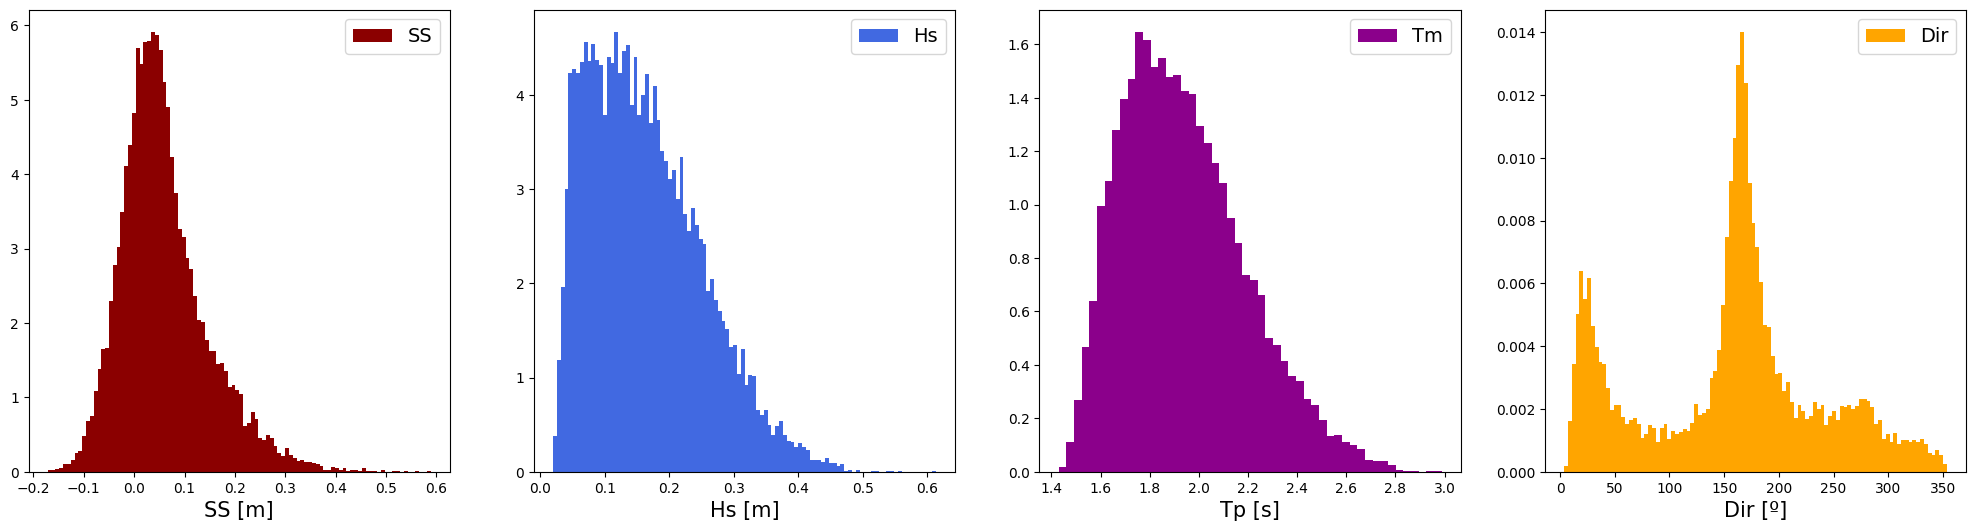

In [12]:
fig, axs = plt.subplots(1, 4, figsize = [25, 6])
axs[0].hist(ds.surge.values, density = True, bins = 100, color = 'darkred', label = 'SS');
axs[0].set_xlabel('SS [m]', fontsize = 15)
axs[0].legend(fontsize = 14)
axs[1].hist(ds.Hs.values, density = True, bins = 100, color = 'royalblue', label = 'Hs');
axs[1].set_xlabel('Hs [m]', fontsize = 15)
axs[1].legend(fontsize = 14)
axs[2].hist(ds.Tm.values, density = True, bins = 50, color = 'darkmagenta', label = 'Tm');
axs[2].set_xlabel('Tp [s]', fontsize = 15)
axs[2].legend(fontsize = 14)
axs[3].hist(ds.Dir.values, density = True, bins = 100, color = 'orange', label = 'Dir');
axs[3].set_xlabel('Dir [º]', fontsize = 15)
axs[3].legend(fontsize = 14)


---

## **5. PRINCIPAL COMPONENT ANALYSIS**

In [11]:
SLP_d = xds_SLP.copy()

In [12]:
# calculate PCA
PCA = PCA_EstelaPred_slp_grd(SLP_d, 'slp')
print(PCA)

<xarray.Dataset> Size: 278MB
Dimensions:        (time: 30502, n_components: 1100, n_features: 1100,
                    n_lon: 22, n_lat: 25, n_points: 1100)
Dimensions without coordinates: time, n_components, n_features, n_lon, n_lat,
                                n_points
Data variables:
    PCs            (time, n_components) float64 268MB 32.04 ... -4.284e-19
    EOFs           (n_components, n_features) float64 10MB 0.03062 ... -0.0
    variance       (n_components) float64 9kB 394.9 152.3 ... 1.123e-34
    pred_mean      (n_features) float64 9kB 1.011e+05 1.01e+05 ... 0.0 0.0
    pred_std       (n_features) float64 9kB 172.6 161.4 151.7 ... 0.0 0.0 0.0
    pred_lon       (n_lon) float32 88B 98.38 99.38 100.4 ... 117.4 118.4 119.4
    pred_lat       (n_lat) float32 100B -9.375 -8.375 -7.375 ... 13.62 14.62
    pred_time      (time) datetime64[ns] 244kB 1940-01-01 ... 2023-07-05
    pred_data_pos  (n_points) bool 1kB True True True True ... True True True
Attributes:
    method: 

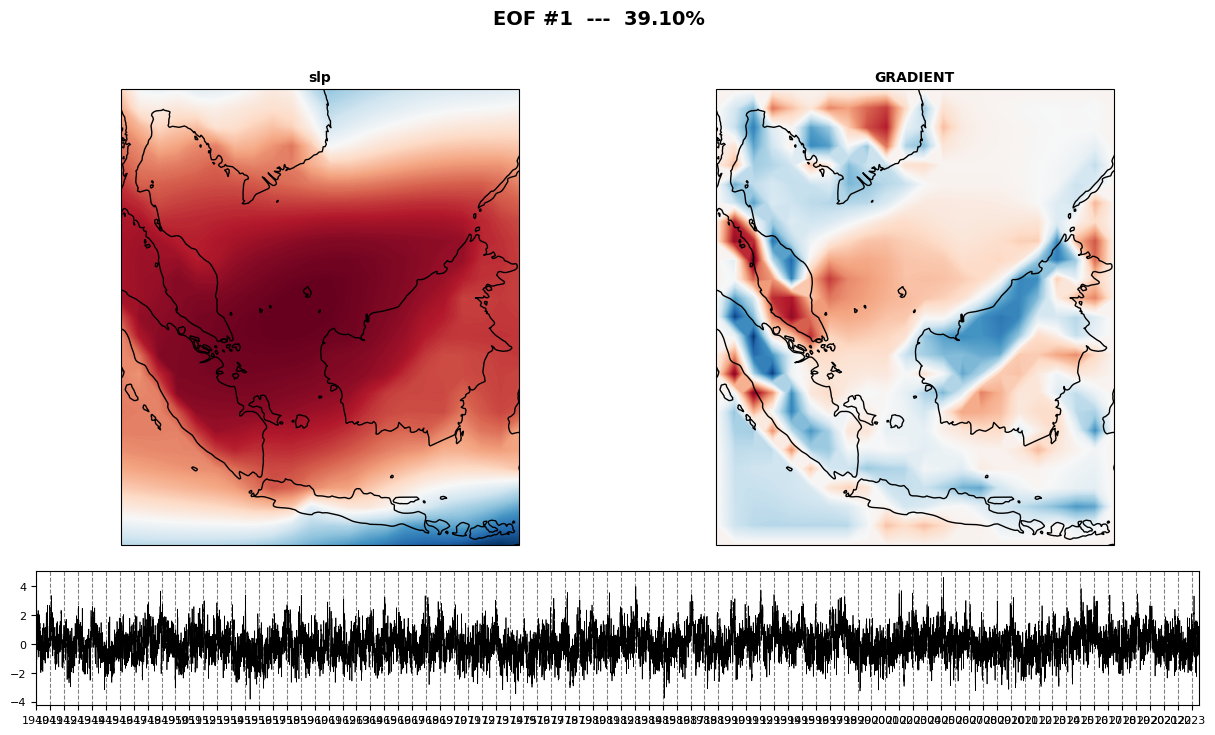

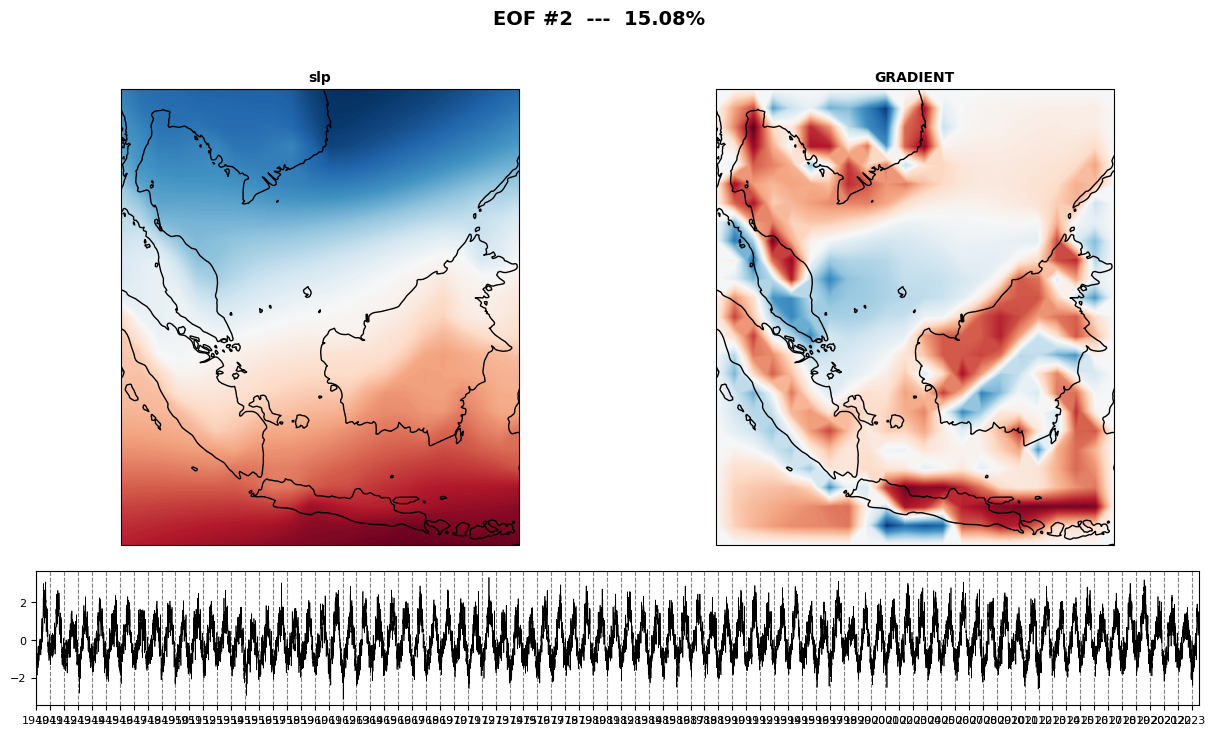

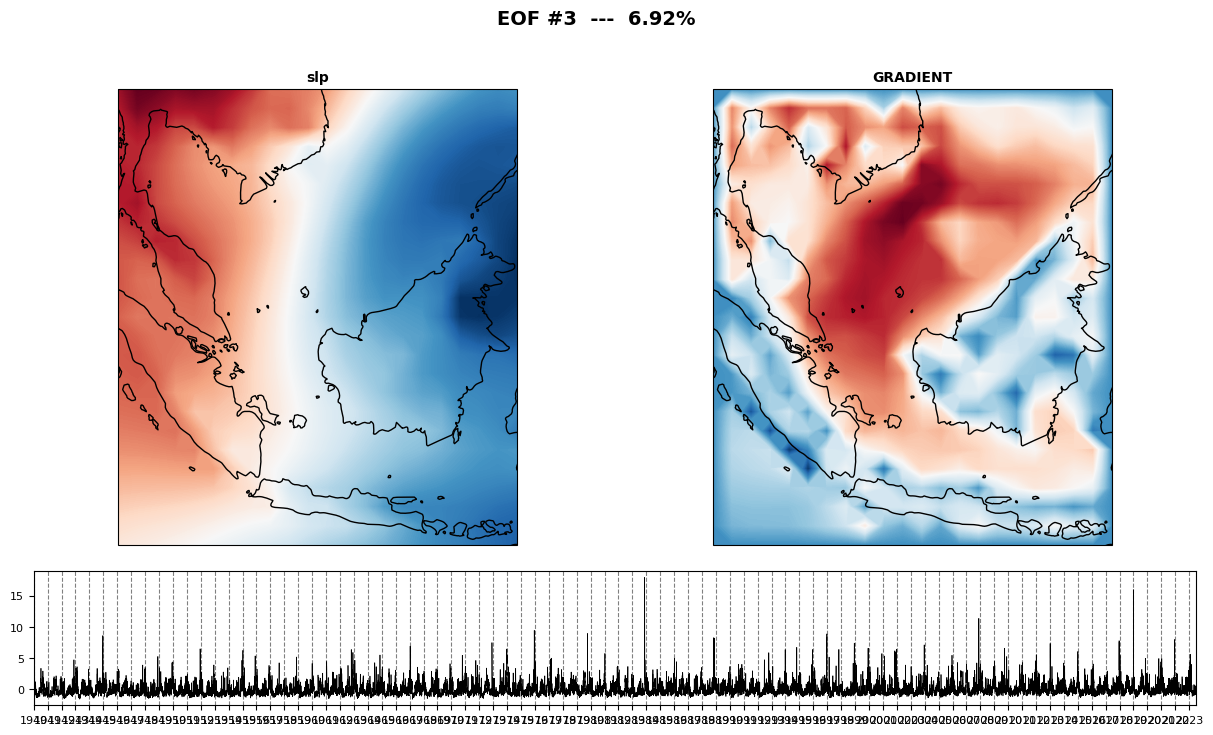

In [13]:
# plot PCA EOFs
n_EOFs = 3
vmin=-2
vmax=2

Plot_EOFs_EstelaPred(PCA, n_EOFs, show=True, figsize = [15,8] );

In [14]:
SLP_d = SLP_d.rename({'slp_comp':'slp', 'slp_gradient_comp':'slp_gradient'}) #match format dynamic predictor

---

## **6. K-MEANS CLASSIFICATION**

In [15]:
num_clusters = 25
c_dwt = colors_dwt(num_clusters)

In [16]:
# Calculate KMA (simple regression)

# t = 20 m -> repres=0.95

KMA = slp_kmeans_clustering(PCA, repres=0.95, num_clusters=num_clusters, min_data=5)

KMA['time']=(('n_components'), PCA.pred_time.values)
print(KMA)

# float to int
KMA['sorted_bmus'].values = KMA['sorted_bmus'].values.astype(np.int32)

print(KMA)

Number of PCs: 1100
Number of PCs explaining 90.0% of the EV is: 41
Iteration: 10695

In [20]:
KMA.to_netcdf(op.join(p_out, 'DWT_KMA_eofs.nc'))

In [17]:
KMA = xr.open_dataset(op.join(p_out,'DWT_KMA_eofs.nc'))

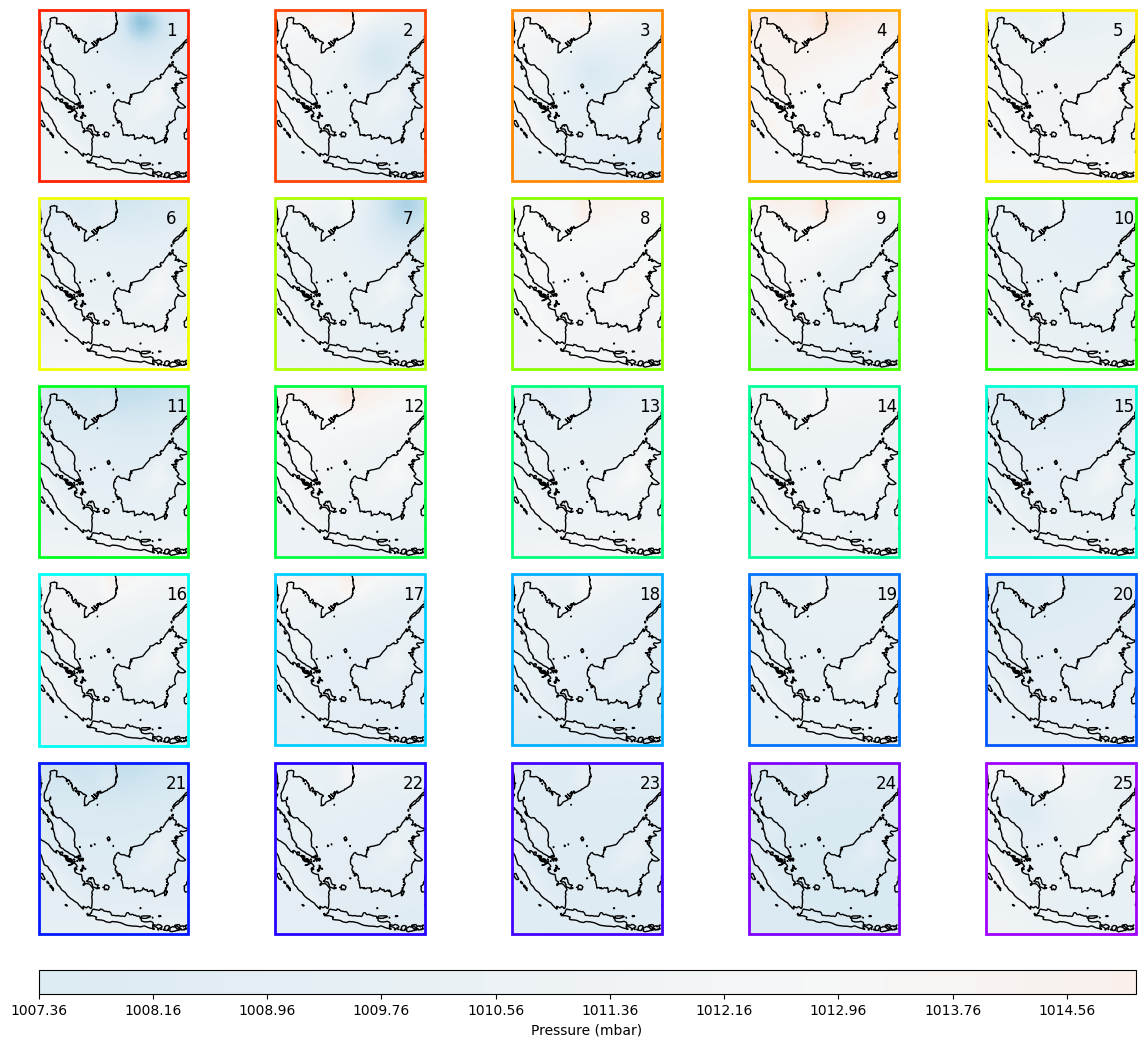

In [18]:
# Plot DWTs (data mean)
Plot_DWTs_Mean_Anom(KMA, SLP_d['slp'], mask_land = False, kind='mean', figsize = [15, 12]);

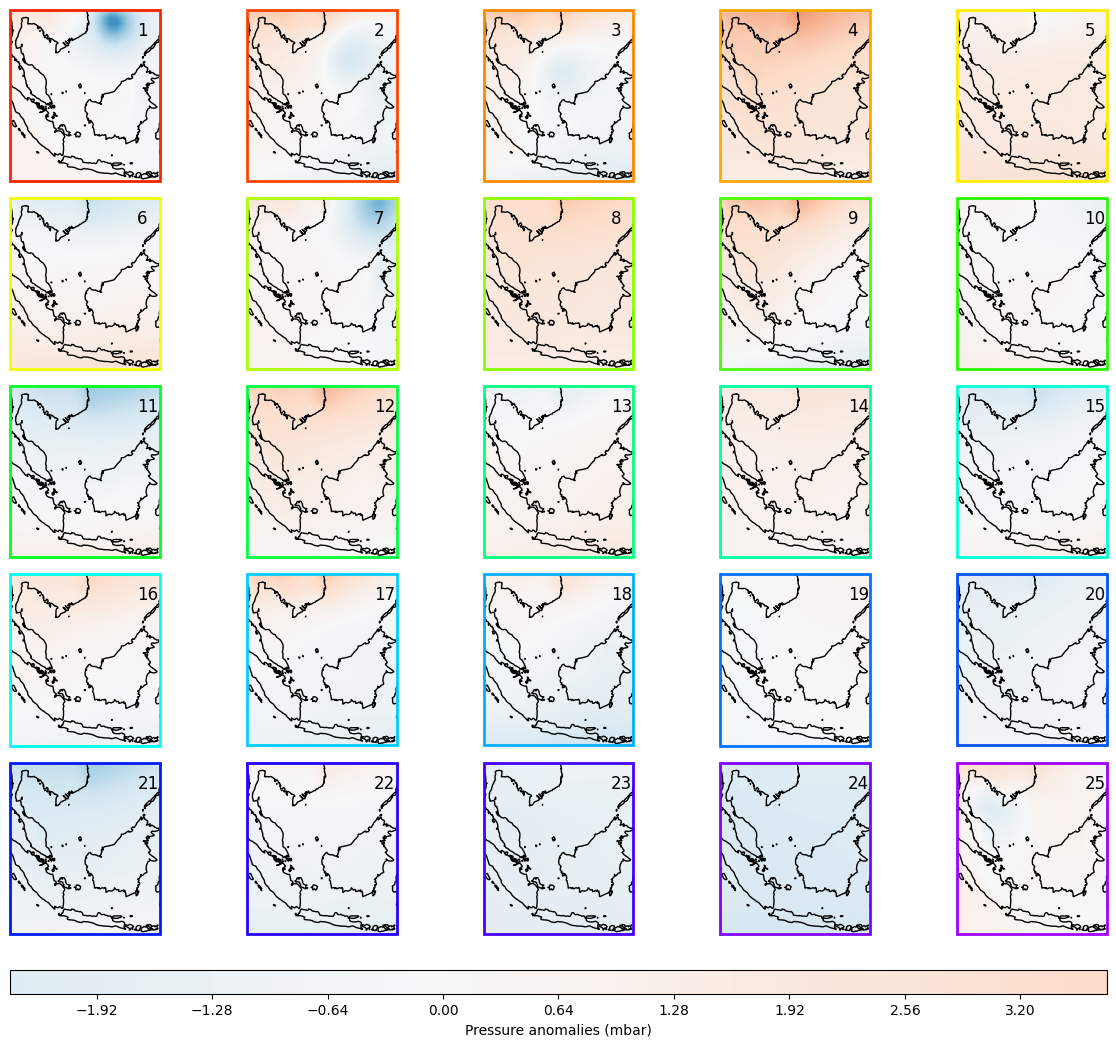

In [19]:
# Plot DWTs (data anomalies)
Plot_DWTs_Mean_Anom(KMA, SLP_d['slp'], kind='anom', figsize = [15, 12], cbar_anom = 20);

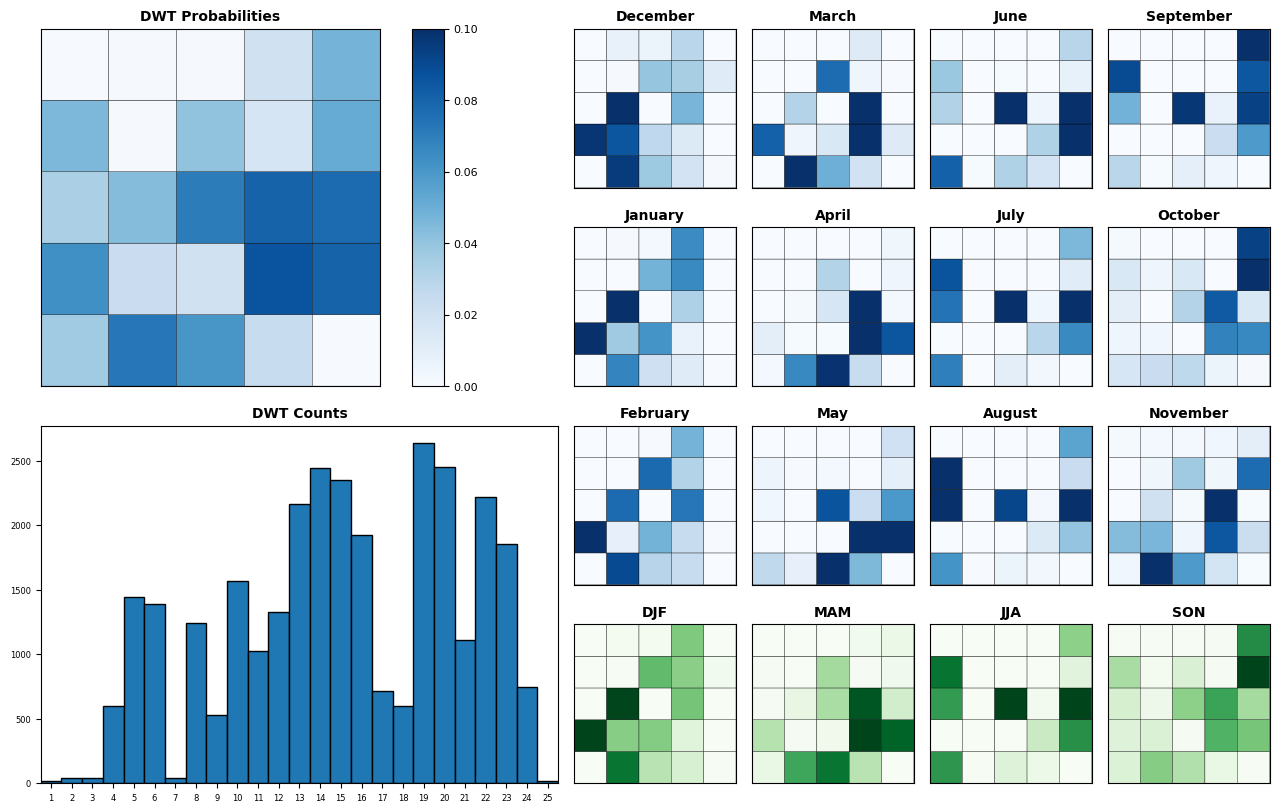

In [20]:
# Plot DWTs Probabilities

bmus = KMA['sorted_bmus'].values[:] + 1 # index to DWT id
bmus_time = KMA['time'].values[:]

Plot_DWTs_Probs(bmus, bmus_time, num_clusters, show=True);

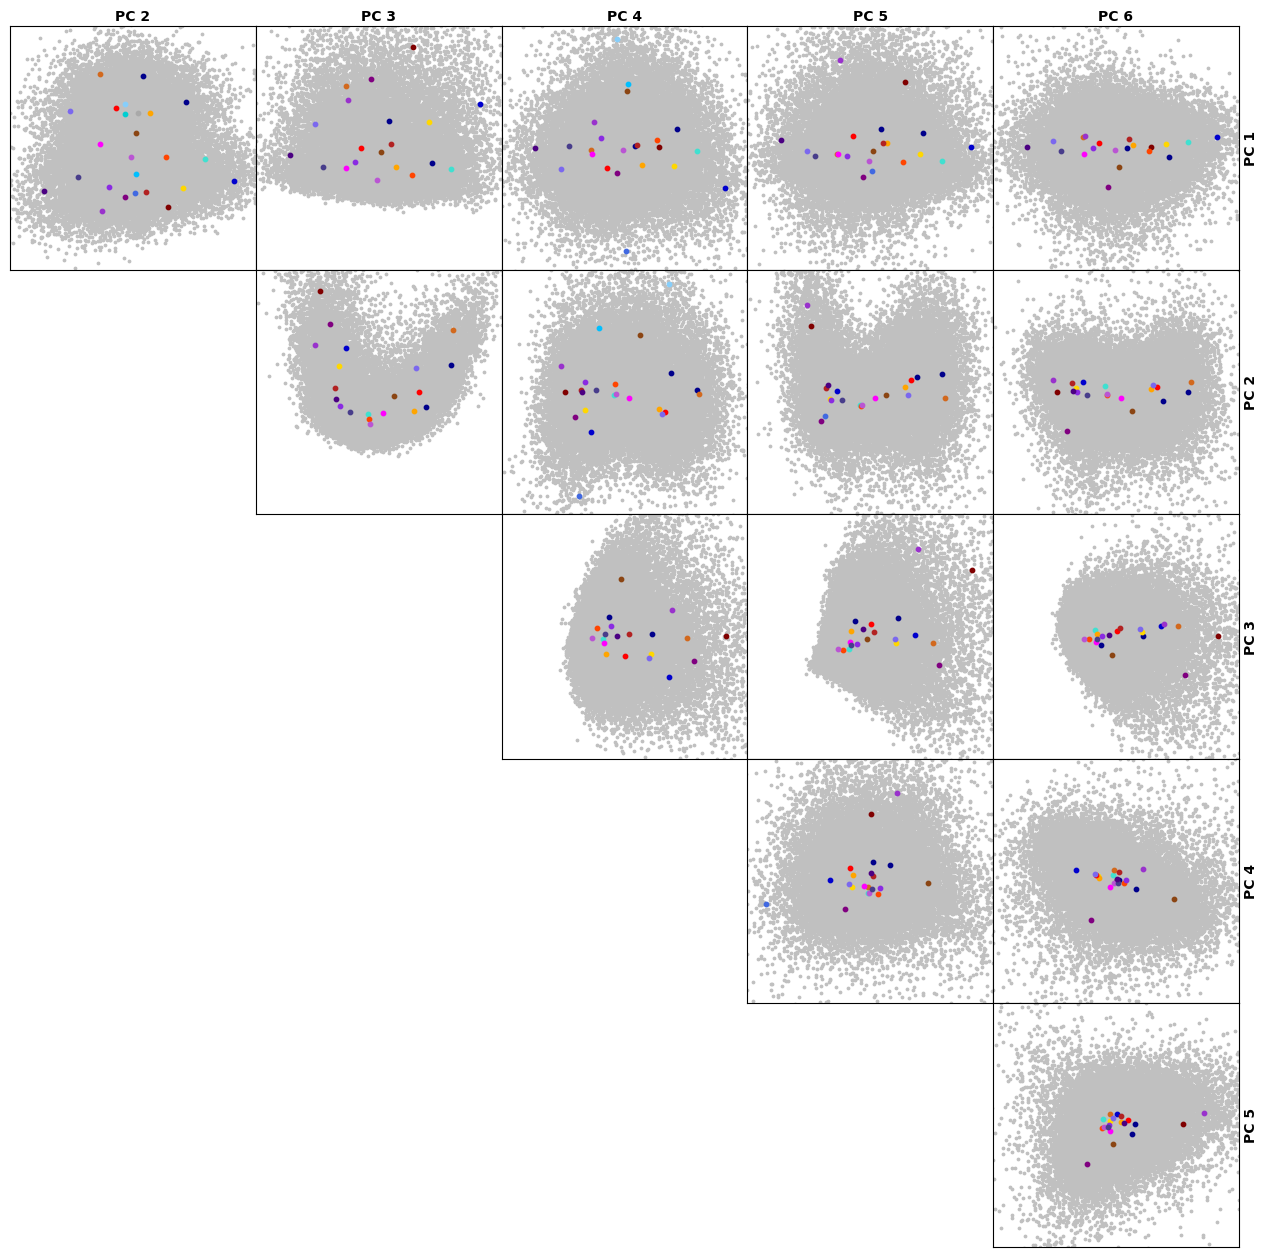

In [21]:
# Plot PCs DWT centroids

# prepare data
PCs = PCA.PCs.values[:]
variance = PCA.variance.values[:]
bmus = KMA.sorted_bmus.values[:]  # sorted_bmus
n_clusters = len(KMA.n_clusters.values[:])

# Plot DWTs PCs
Plot_PCs_WT(PCs, variance, bmus, n_clusters, n=6);

In [22]:
SLP_d['cluster'] = (('time'), bmus)
SLP_d

<xarray.Dataset> Size: 202MB
Dimensions:       (time: 30502, latitude: 25, longitude: 22)
Coordinates:
  * longitude     (longitude) float32 88B 98.38 99.38 100.4 ... 118.4 119.4
  * latitude      (latitude) float32 100B -9.375 -8.375 -7.375 ... 13.62 14.62
  * time          (time) datetime64[ns] 244kB 1940-01-01 ... 2023-07-05
Data variables:
    slp           (time, latitude, longitude) float32 67MB 1.007e+05 ... 1.00...
    slp_gradient  (time, latitude, longitude) float64 134MB 0.0 0.0 ... 0.0 0.0
    cluster       (time) int32 122kB 11 11 8 8 1 1 17 17 ... 12 12 4 4 12 12 9

---

## **7. PREDICTAND ASSOCIATED TO EACH DWT**

In [ ]:
waves_ds['SS'] = SS_ds.surge
_, ia, ib = np.intersect1d(SLP_d.time.values, waves_ds.time.values, return_indices=True)
waves_ds['bmus'] = SLP_d.cluster.isel(time = ia)

Text(0.5, 0.94, 'Hs')

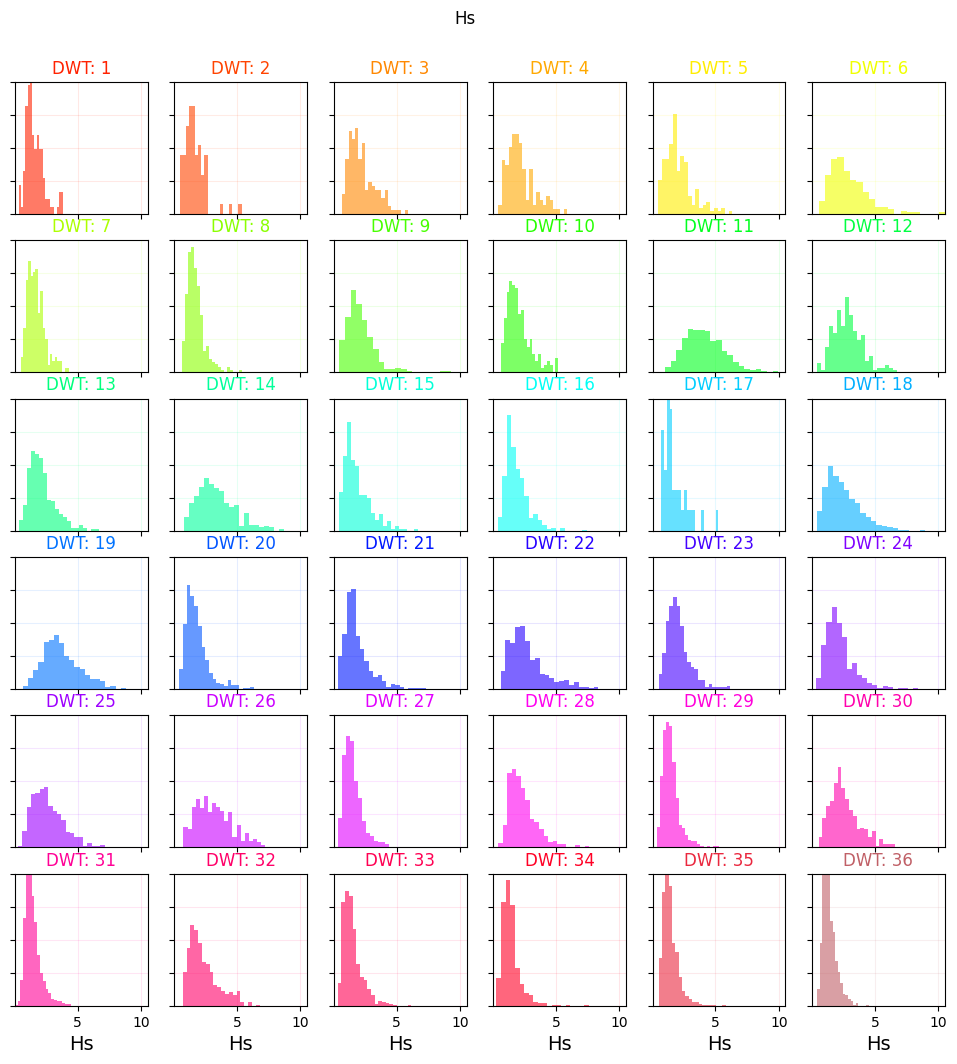

In [ ]:
var = 'Hs'

fig = plt.figure(figsize = [12, 12])
gs = gridspec.GridSpec(6,6)

for i_cluster in range(36):

    ax = fig.add_subplot(gs[i_cluster])
    ax.hist(waves_ds.where(waves_ds.bmus == i_cluster, drop = True)[var].values, density = True, bins = 20, color = c_dwt[i_cluster], alpha = .6, zorder=2);
    ax.set_xlim(waves_ds[var].values.min(), waves_ds[var].values.max())
    ax.set_ylim([0, .8])
    ax.set_title('DWT: {0}'.format(i_cluster+1), color =  c_dwt[i_cluster])
    ax.set_yticklabels([])
    ax.grid(':', color =  c_dwt[i_cluster], alpha = .1)

    if i_cluster < 30:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('{0}'.format(var), fontsize = 14)

fig.suptitle(var, y = 0.94)

Text(0.5, 0.5, 'Tp')

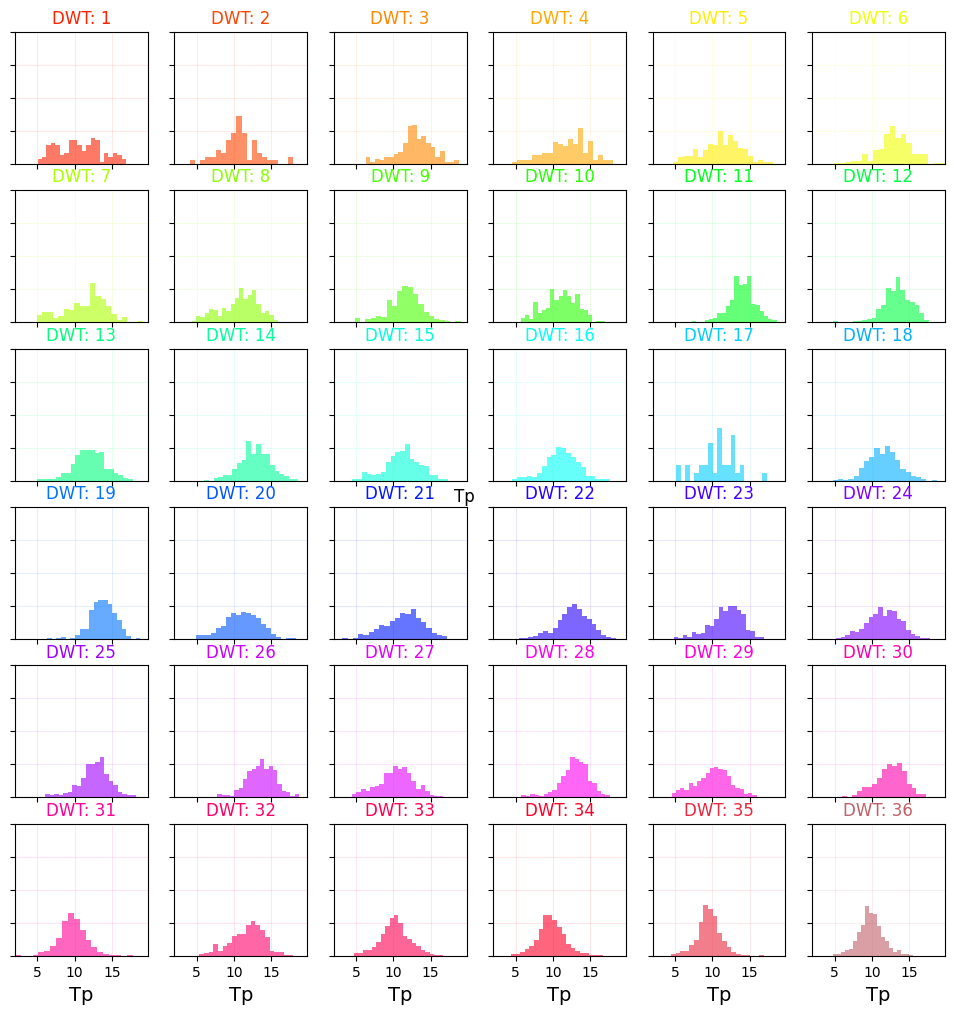

In [ ]:
var = 'Tp'

fig = plt.figure(figsize = [12, 12])
gs = gridspec.GridSpec(6,6)

for i_cluster in range(36):

    ax = fig.add_subplot(gs[i_cluster])
    ax.hist(waves_ds.where(waves_ds.bmus == i_cluster, drop = True)[var].values, density = True, bins = 20, color = c_dwt[i_cluster], alpha = .6, zorder=2);
    ax.set_xlim(waves_ds[var].values.min(), waves_ds[var].values.max())
    ax.set_ylim([0, .8])
    ax.set_title('DWT: {0}'.format(i_cluster+1), color =  c_dwt[i_cluster])
    ax.set_yticklabels([])
    ax.grid(':', color =  c_dwt[i_cluster], alpha = .1)

    if i_cluster < 30:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('{0}'.format(var), fontsize = 14)

fig.suptitle(var, y = 0.5)

Text(0.5, 0.94, 'Dir')

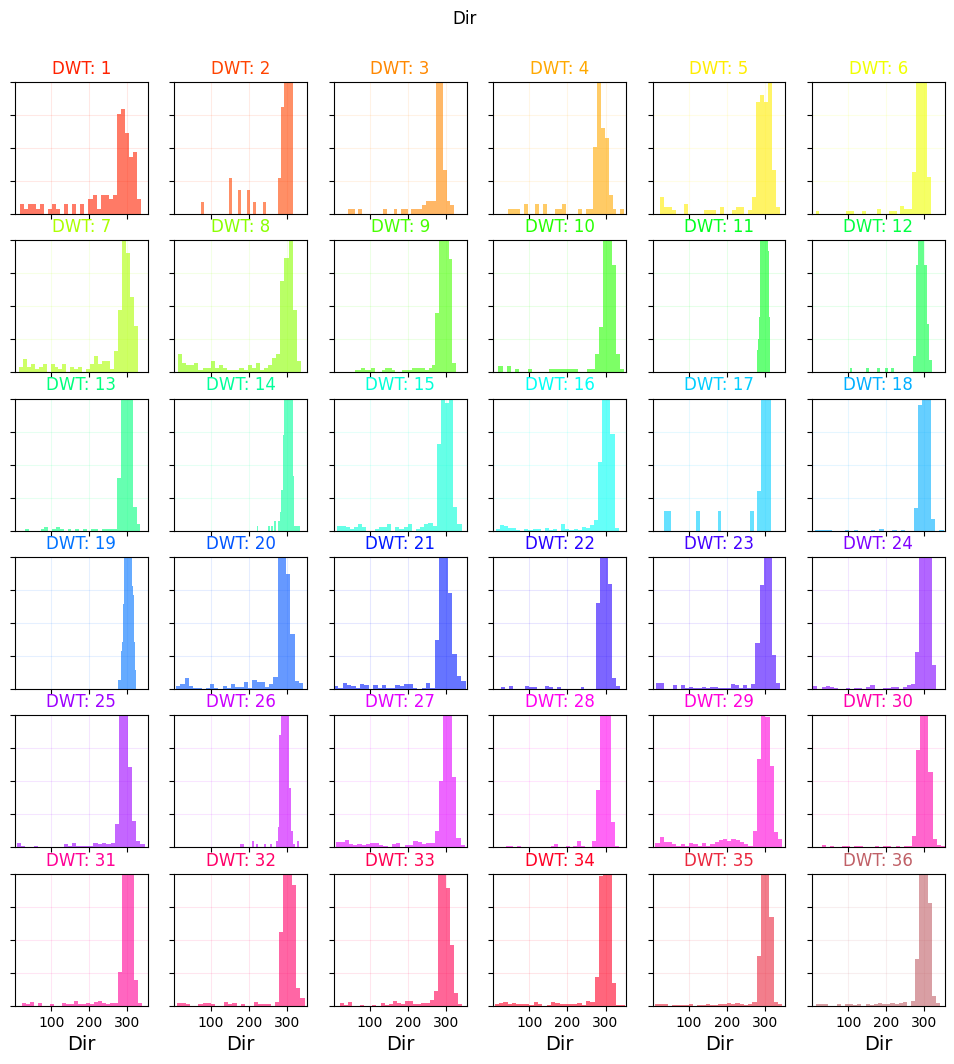

In [ ]:
var = 'Dir'

fig = plt.figure(figsize = [12, 12])
gs = gridspec.GridSpec(6,6)

for i_cluster in range(36):

    ax = fig.add_subplot(gs[i_cluster])
    ax.hist(waves_ds.where(waves_ds.bmus == i_cluster, drop = True)[var].values, density = True, bins = 30, color = c_dwt[i_cluster], alpha = .6, zorder=2);
    ax.set_xlim(waves_ds[var].values.min(), waves_ds[var].values.max())
    ax.set_ylim([0, .02])
    ax.set_title('DWT: {0}'.format(i_cluster+1), color =  c_dwt[i_cluster])
    ax.set_yticklabels([])
    ax.grid(':', color =  c_dwt[i_cluster], alpha = .1)

    if i_cluster < 30:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('{0}'.format(var), fontsize = 14)

fig.suptitle(var, y = 0.94)

---

## **8. SAVE DATA**

In [24]:
SLP_d.to_netcdf(op.join(p_out, 'SLP_KMA.nc'))
waves_ds.to_netcdf(op.join(p_out, 'outputs', 'Waves_SS_precip_KMA.nc'))